### A. IMPORT THE DATASET

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

In [ ]:
uploaded=files.upload()

Saving covid19_tweets.csv to covid19_tweets.csv


In [ ]:
df=pd.read_csv("covid19_tweets.csv")

### B. EXPLORATORY DATA ANALYSIS

In [ ]:
df.shape # Dimensions of the dataset

(179108, 13)

In [ ]:
df.tail() # last five rows of the dataset

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
179103,AJIMATI AbdulRahman O.,"Ilorin, Nigeria",Animal Scientist|| Muslim|| Real Madrid/Chelsea,2013-12-30 18:59:19,412,1609,1062,False,2020-08-29 19:44:21,Thanks @IamOhmai for nominating me for the @WH...,['WearAMask'],Twitter for Android,False
179104,Jason,Ontario,When your cat has more baking soda than Ninja ...,2011-12-21 04:41:30,150,182,7295,False,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 http...,['COVID19'],Twitter for Android,False
179105,BEEHEMOTH ⏳,🇨🇦 Canada,⚒️ The Architects of Free Trade ⚒️ Really Did ...,2016-07-13 17:21:59,1623,2160,98000,False,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. I...,NaN,Twitter Web App,False
179106,Gary DelPonte,New York City,"Global UX UI Visual Designer. StoryTeller, Mus...",2009-10-27 17:43:13,1338,1111,0,False,2020-08-29 19:44:14,"More than 1,200 students test positive for #CO...",['COVID19'],Twitter for iPhone,False
179107,TUKY II,"Aliwal North, South Africa",TOKELO SEKHOPA | TUKY II | LAST BORN | EISH TU...,2018-04-14 17:30:07,97,1697,566,False,2020-08-29 19:44:08,I stop when I see a Stop\n\n@SABCNews\n@Izinda...,NaN,Twitter for Android,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [ ]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


####  DETERMINE THE MISSING VALUES AND PLOT THEM

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def return_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()/len(data_frame)
    missing_values = missing_values[missing_values>0]
    missing_values.sort_values(inplace=True)
    return missing_values

def plot_missing_values(data_frame):
    missing_values = return_missing_values(data_frame)
    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index
    sns.set(style='whitegrid', color_codes=True)
    sns.barplot(x='Name', y='count', data=missing_values)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
return_missing_values(df)

source              0.000430
user_description    0.057429
user_location       0.205301
hashtags            0.286609
dtype: float64

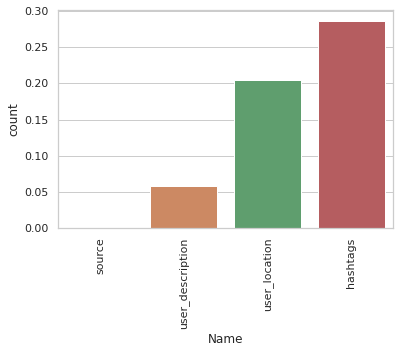

In [ ]:
plot_missing_values(df)

#### DETERMINE THE UNIQUE VALUES AND PLOT THEM

In [ ]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [ ]:
udf = return_unique_values(df)
print(udf)

            Features  Uniques
0          user_name    92276
1      user_location    26920
2   user_description    89200
3       user_created    93708
4     user_followers    27694
5       user_friends    11022
6    user_favourites    35259
7      user_verified        2
8               date   136611
9               text   178683
10          hashtags    52640
11            source      610
12        is_retweet        1


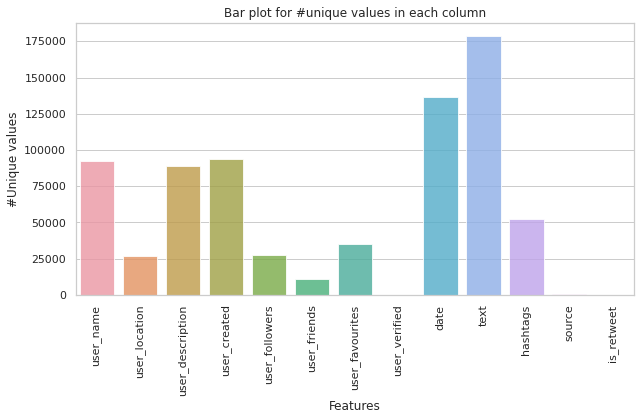

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,5))#plt.figure(figsize=(10, 5))

sns.barplot(x=udf['Features'], y=udf['Uniques'], alpha=0.8)
plt.title('Bar plot for #unique values in each column')
plt.ylabel('#Unique values', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()


In [ ]:
! pip install pycountry

     |████████████████████████████████| 10.1MB 4.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=3732b71289a4478df03b21960e941a356617a48d027c7a50c3be443955eca058
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


### IMPORT ALL THE REQUIRED LIBRARIES

In [ ]:
import pycountry
import warnings
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.dates as mdates
import re
import string
from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils import shuffle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.regularizers import l2

np.random_seed = 0


warnings.filterwarnings('ignore')

In [ ]:
df['user_location'].fillna('unknown', inplace=True)

In [ ]:
df['user_location'].value_counts()

unknown                       36771
India                          3741
United States                  2455
New Delhi, India               1721
Mumbai, India                  1401
                              ...  
atlanta ga                        1
Southwest UK                      1
San Antonio, Texas, U.S.A.        1
San Francisco/New York            1
Bonney Lake, WA                   1
Name: user_location, Length: 26921, dtype: int64

In [ ]:
c = list(pycountry.countries)

In [ ]:
def correct_location(x):
    for i in c:
        if str(i.name).lower() in x or str(i.alpha_2).lower() in x.split() or str(i.alpha_3).lower() in x.split():
            return str(i.name)
    return x

In [ ]:
df['user_location'] = df['user_location'].apply(lambda x: correct_location(x.lower()))

In [ ]:
df['user_location'].value_counts()

unknown                      36776
India                        15769
United States                 9608
Canada                        6349
Australia                     2957
                             ...  
moonbase alpha                   1
seattle/portland                 1
'papa kommt immer wieder'        1
derby, midlands, uk              1
downtown, vancouver              1
Name: user_location, Length: 16891, dtype: int64

### DATA VISUALIZATION THROUGH BAR PLOTS AND WORD CLOUD

##### 1. TWEET COUNT BASED ON LOCATION

In [ ]:
def plot_bar(x,y,title,x_label,y_label):
    fig = go.Figure(data=[go.Bar(
                x=x,
                y=y,
                text=y,
                textposition='auto',
            )])

    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label
    )

    fig.show()

In [ ]:
plot_bar(df['user_location'].value_counts().index[0:20],
         df['user_location'].value_counts().values[0:20],
         "Top 20 Locations by the number of tweets",
         "Location",
         "Tweet Count")


##### 2. TIME SERIES PLOT

In [ ]:
def plot_time_series(dates, counts, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Configure x-ticks
    ax.set_xticks(dates) # Tickmark + label at every plotted point
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
   
    ax.plot_date(dates, counts, ls='-', marker='o')
    ax.set_title(title)
    ax.set_ylabel('Tweet Count)')
    ax.grid(True)

    # Format the x-axis for dates (label formatting, rotation)
    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()

    fig.show()

In [ ]:
df['just_date'] = pd.to_datetime(df['date']).dt.normalize()

top = list(df['user_location'].value_counts().index[1:5])
df_top = df[df['user_location'].isin(top)]

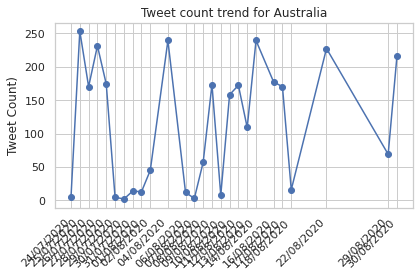

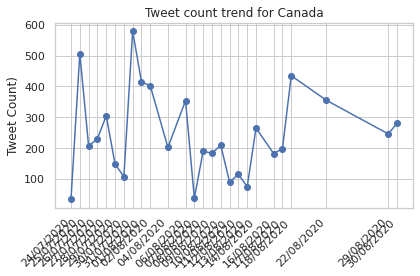

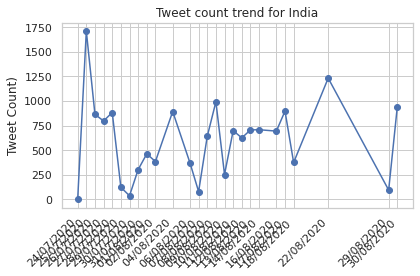

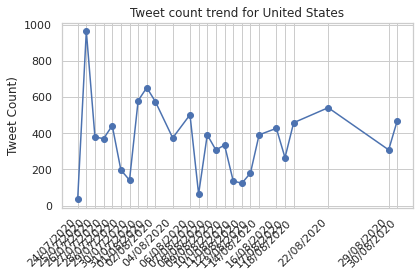

In [ ]:
grp_df = df_top.groupby('user_location')
for i, grp in grp_df:
    dates = grp['just_date'].value_counts().sort_index().index
    counts = grp['just_date'].value_counts().sort_index().values
        
    plot_time_series(dates,counts,'Tweet count trend for '+i)


##### 3. TWEETER SOURCES BASED ON TWEET COUNT

In [ ]:
plot_bar(df['source'].value_counts().index[0:20],
         df['source'].value_counts().values[0:20],
         "Top 20 Tweeter Sources by the number of tweets",
         "Source",
         "Tweet Count")

##### 4. CORRELATION MATRIX

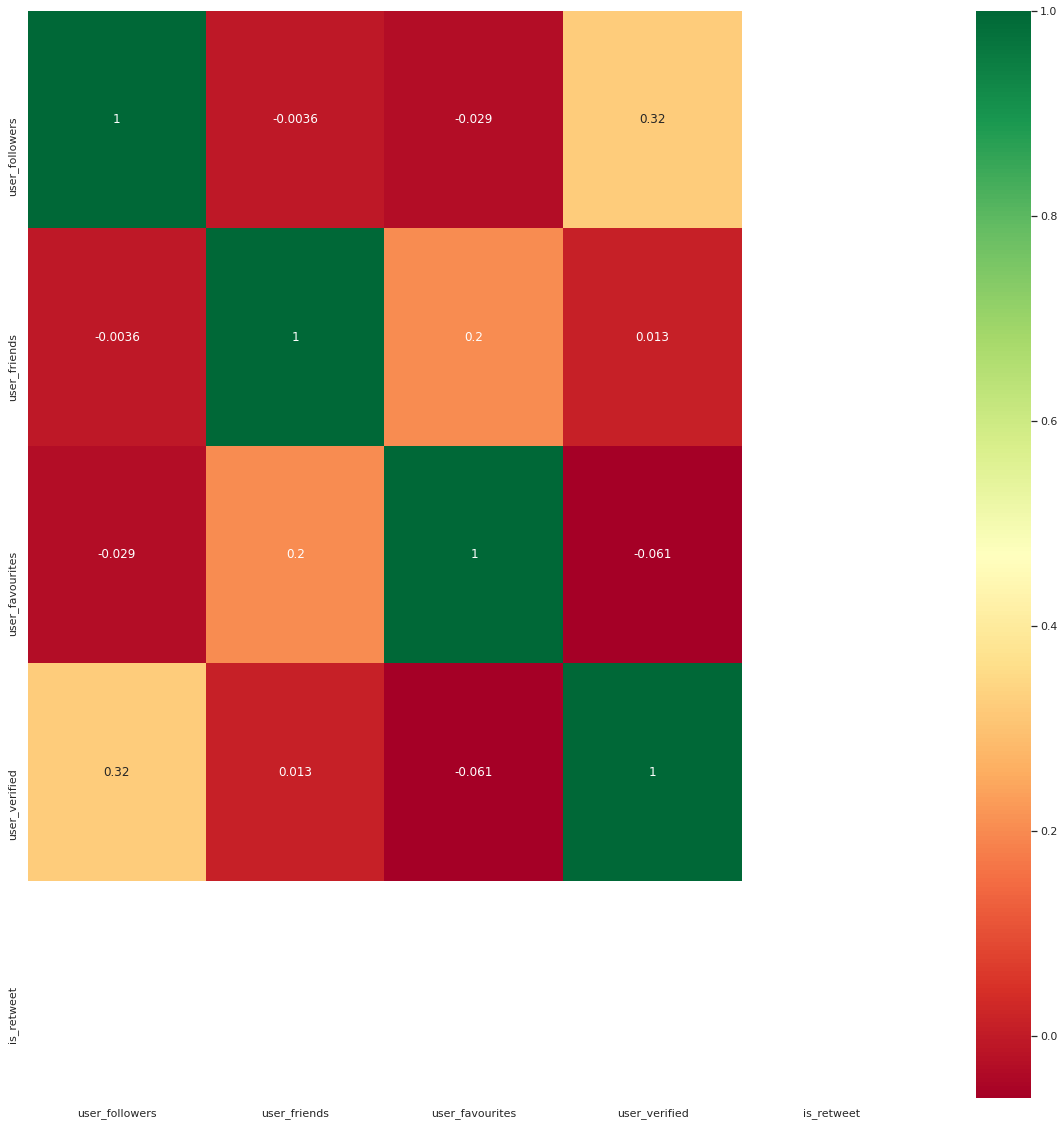

In [ ]:
# Find correlation of each feature present in the dataset.
corr_mat=df.corr()
corr_features=corr_mat.index
plt.figure(figsize=(20,20))
mat=sns.heatmap(df[corr_features].corr(),annot=True,cmap="RdYlGn")

##### 5. WORDCLOUD FOR TWEETS AND HASHTAGS

In [ ]:
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

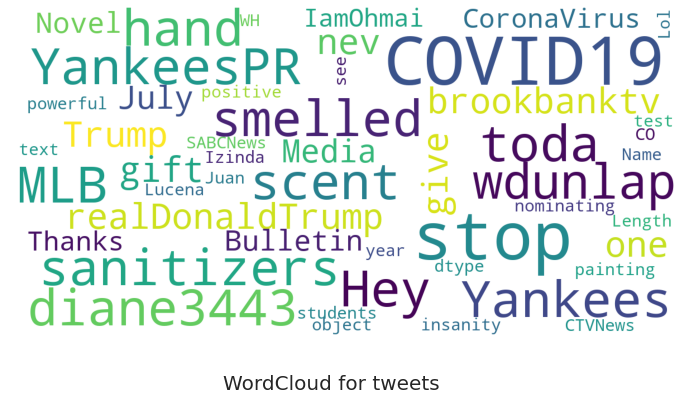

In [ ]:
show_wordcloud(df['text'], "WordCloud for tweets")

In [ ]:
hashtags = list(df['hashtags'].dropna())

hashtags = [x.replace("'", '') for x in hashtags]
hashtags = [(re.sub(r'[^\w\s]','',x)).lower() for x in hashtags]


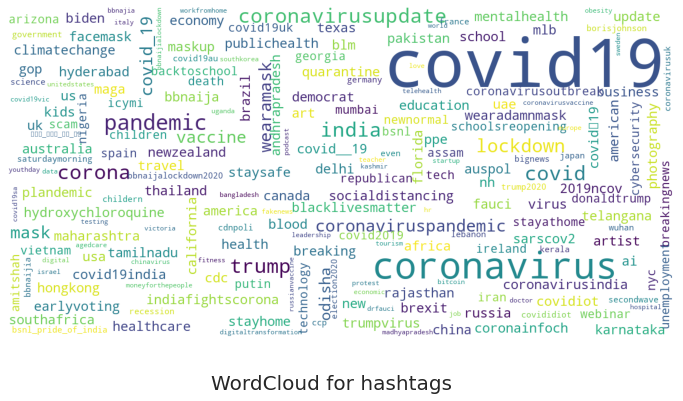

In [ ]:
show_wordcloud(' '.join(hashtags),"WordCloud for hashtags")

##### 6. VISUALIZING TOP 50 WORDS BASED ON LOCATION

In [ ]:
import nltk
nltk.download('stopwords')

from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english')[10:15])

def punctuation_stopwords_removal(sms):
    # filters character-by-character : ['h', 'e', 'e', 'l', 'o', 'o', ' ', 'm', 'y', ' ', 'n', 'a', 'm', 'e', ' ', 'i', 's', ' ', 'p', 'u', 'r', 'v', 'a']
    remove_punctuation = [ch for ch in sms if ch not in punctuation]
    # convert them back to sentences and split into words
    remove_punctuation = "".join(remove_punctuation).split()
    filtered_sms = [word.lower() for word in remove_punctuation if word.lower() not in stopwords.words('english')]
    return filtered_sms

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
["you've", "you'll", "you'd", 'your', 'yours']


In [ ]:
from collections import Counter

def draw_bar_graph_for_text_visualization(df, location):
    tweets_from_loc = df.loc[df.user_location==location]
    tweets_from_loc.loc[:, 'text'] = tweets_from_loc['text'].apply(punctuation_stopwords_removal)
    loc_tweets_curated = tweets_from_loc['text'].tolist()
    loc_tweet_list = []
    for sublist in loc_tweets_curated:
        for word in sublist:
            loc_tweet_list.append(word)
    loc_tweet_count = Counter(loc_tweet_list)
    loc_top_50_words = pd.DataFrame(loc_tweet_count.most_common(50), columns=['word', 'count'])
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.barplot(x='word', y='count', 
                data=loc_top_50_words, ax=ax)
    plt.title("Top 50 Prevalent Words in {}".format(location))
    plt.xticks(rotation='vertical');

In [ ]:
from wordcloud import WordCloud, STOPWORDS



def draw_word_cloud(df, location, title):
    loc_df = df.loc[df.user_location==location]
    loc_df.loc[:, 'text'] = loc_df['text'].apply(punctuation_stopwords_removal)
    word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(loc_df['text']))
    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(word_cloud)
    plt.show()

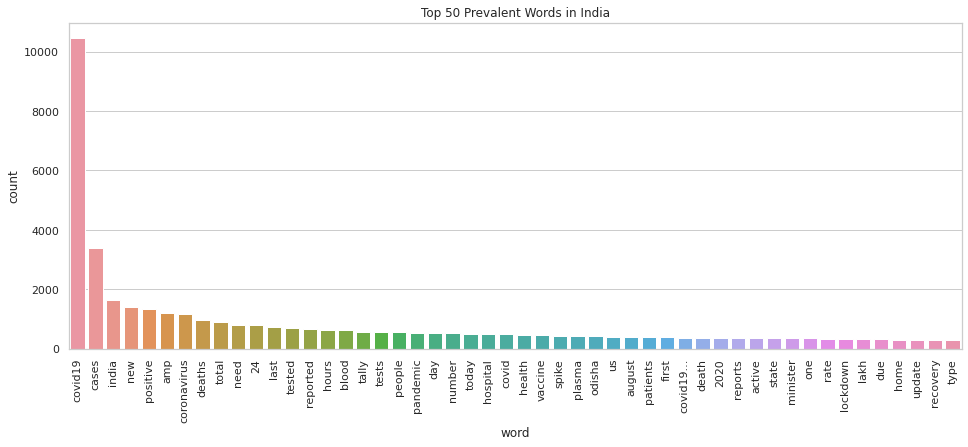

In [ ]:
draw_bar_graph_for_text_visualization(df, 'India')

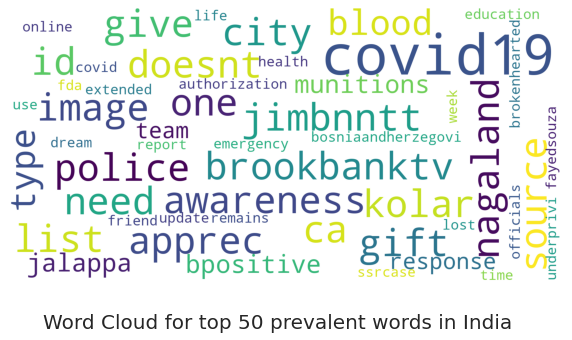

In [ ]:
draw_word_cloud(df, 'India', 'Word Cloud for top 50 prevalent words in India')

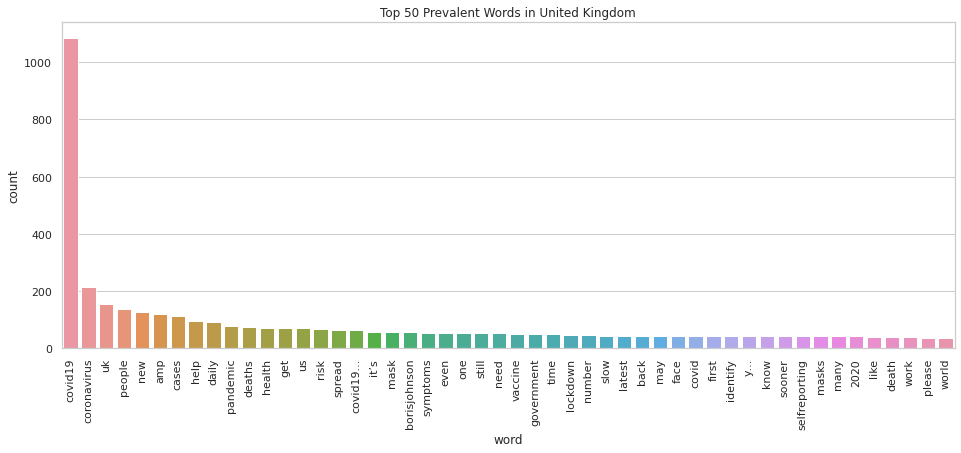

In [ ]:
draw_bar_graph_for_text_visualization(df, 'United Kingdom')

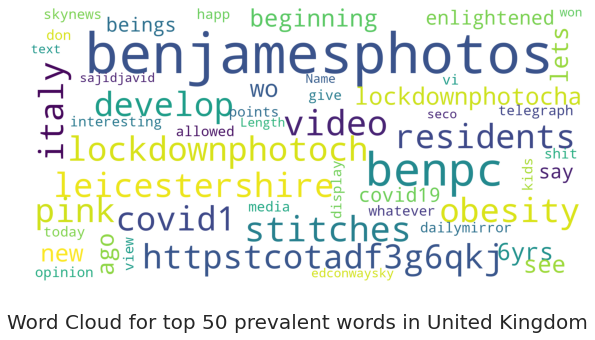

In [ ]:
draw_word_cloud(df, 'United Kingdom', 'Word Cloud for top 50 prevalent words in United Kingdom')

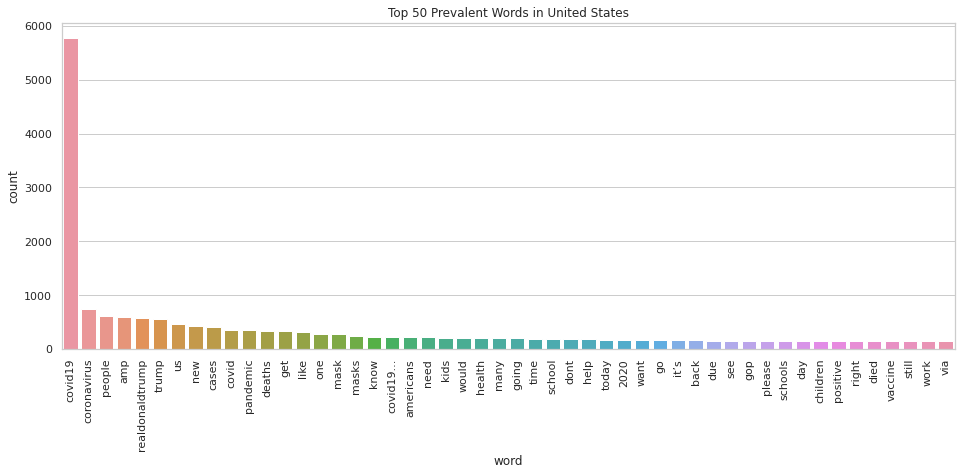

In [ ]:
draw_bar_graph_for_text_visualization(df, 'United States')

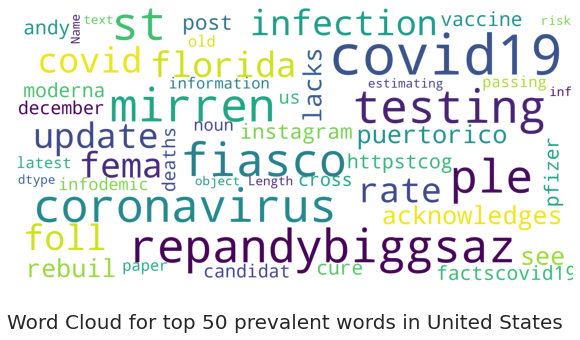

In [ ]:
draw_word_cloud(df, 'United States', 'Word Cloud for top 50 prevalent words in United States')

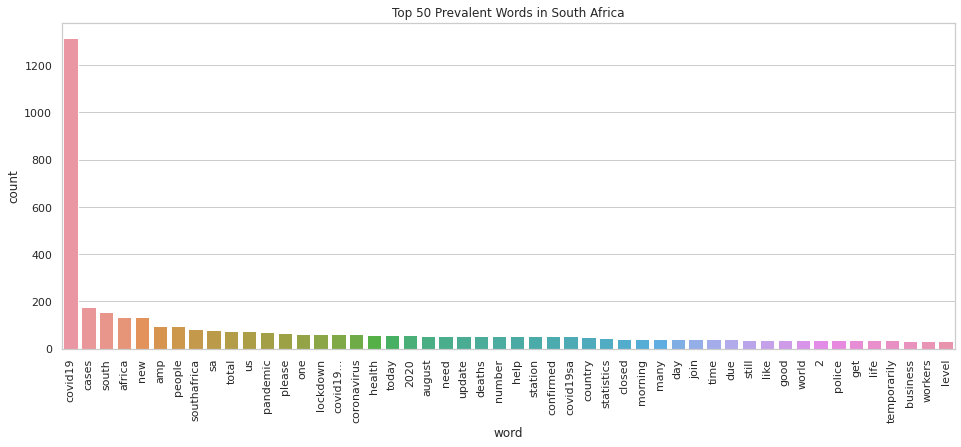

In [ ]:
draw_bar_graph_for_text_visualization(df, 'South Africa')

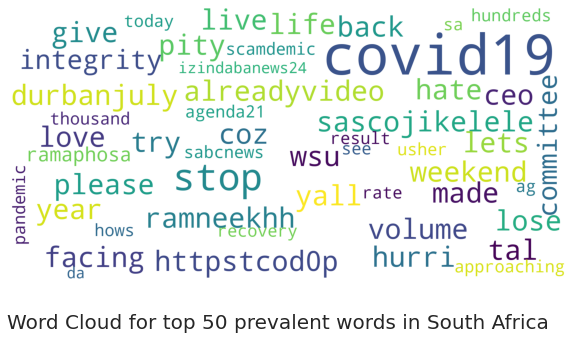

In [ ]:
draw_word_cloud(df, 'South Africa', 'Word Cloud for top 50 prevalent words in South Africa')